# Road Accident Survival

In [11]:
# Importing Libraries
%pip install imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
%matplotlib inline

In [2]:
# Loading dataset
df = pd.read_csv('/content/drive/My Drive/accident.csv')  # Replace with your file path

# Display dataset info
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
df.head()

Dataset Shape: (200, 6)

First 5 Rows:


,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
0,56,Female,27.0,No,No,1
1,69,Female,46.0,No,Yes,1
2,46,Male,46.0,Yes,Yes,0
3,32,Male,117.0,No,Yes,0
4,60,Female,40.0,Yes,Yes,0


## Missing Data

In [3]:
# Check for missing data
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Age                0
Gender             1
Speed_of_Impact    3
Helmet_Used        0
Seatbelt_Used      0
Survived           0
dtype: int64


In [17]:
# Handling missing values
df = df.dropna()
print("Dataset Shape:", df.shape)

Dataset Shape: (196, 6)


## EDA

In [6]:
df.describe()

,Age,Speed_of_Impact,Survived
count,196.000000,196.000000,196.000000
mean,43.341837,70.433673,0.510204
std,15.004973,30.202236,0.501176
min,18.000000,20.000000,0.000000
25%,31.000000,43.000000,0.000000
50%,44.000000,71.000000,1.000000
75%,56.000000,95.500000,1.000000
max,69.000000,119.000000,1.000000


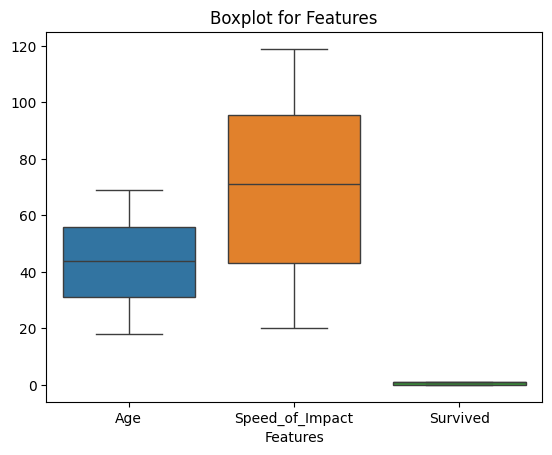

In [8]:
# Boxplot of the numeric features
sns.boxplot(data=df)
plt.title('Boxplot for Features')
plt.xlabel('Features')
plt.show()

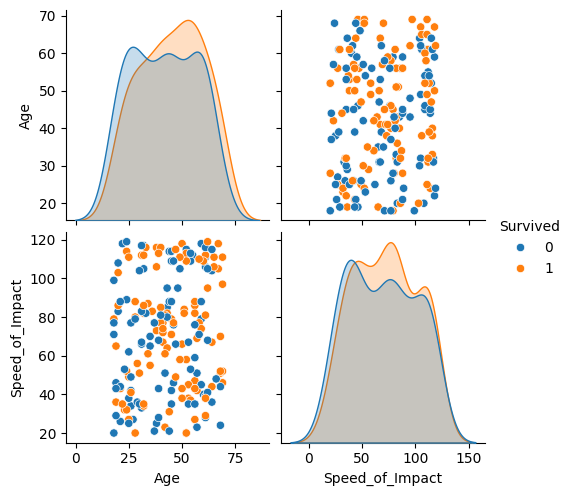

In [20]:
# Pairplot using the target variable as the hue
sns.pairplot(data=df,hue='Survived' )

In [21]:
# Label encoding categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

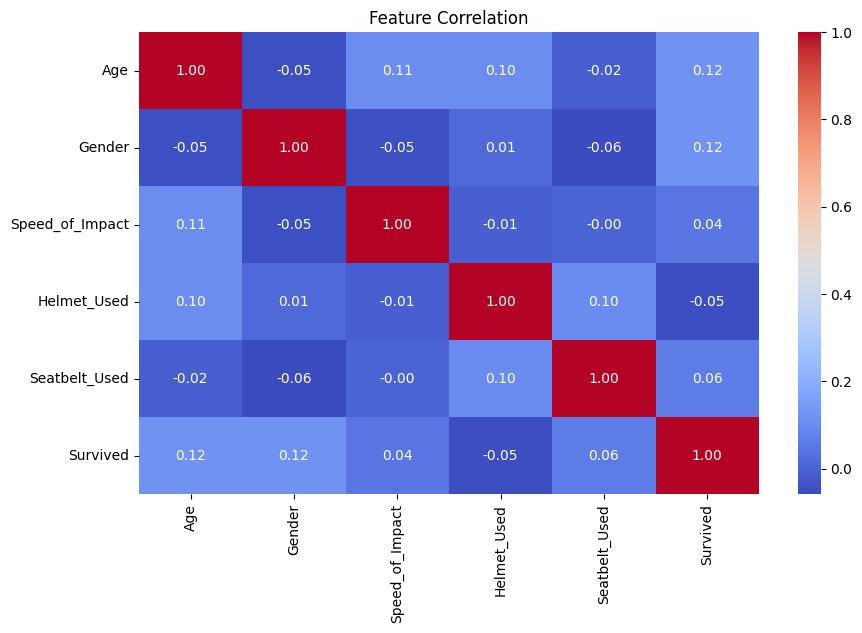

In [22]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation')
plt.show()

## Split Features and Test-train Split

In [23]:
# Split features and target
X = df.drop('Survived', axis=1)  # Replace 'Attendance' with your target column name
y = df['Survived']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Scaling Data

In [24]:
# Feature scaling using standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Balancing Dataset

In [25]:
# Balancing the Dataset (SMOTE: Oversampling using imblearn library)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

## Logistic Regression

In [26]:
#Logistic Regression
lr_balanced = LogisticRegression(random_state=42)
lr_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_lr_balanced = lr_balanced.predict(X_test_scaled)

print("\nLogistic Regression Performance (With Balancing):")
print(classification_report(y_test, y_pred_lr_balanced))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr_balanced))


Logistic Regression Performance (With Balancing):
              precision    recall  f1-score   support

           0       0.58      0.50      0.54        30
           1       0.55      0.62      0.58        29

    accuracy                           0.56        59
   macro avg       0.56      0.56      0.56        59
weighted avg       0.56      0.56      0.56        59

Confusion Matrix:
[[15 15]
 [11 18]]


In [27]:
#Hyperparameter Tuning (Logistic Regression)
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Type of regularization (l1 for Lasso, l2 for Ridge)
    'solver': ['liblinear', 'saga']  # solvers that support l1 and l2 penalties

}

grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5)
grid_search_lr.fit(X_train_balanced, y_train_balanced)

print("\nBest Parameters for Logistic Regression:")
print(grid_search_lr.best_params_)

# Evaluate tuned Logistic Regression Model
best_lr = grid_search_lr.best_estimator_
y_pred_best_lr = best_lr.predict(X_test_scaled)

print("\nTuned Logistic Regression Model Performance:")
print(classification_report(y_test, y_pred_best_lr))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_lr))


Best Parameters for Logistic Regression:
{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Tuned Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.58      0.50      0.54        30
           1       0.55      0.62      0.58        29

    accuracy                           0.56        59
   macro avg       0.56      0.56      0.56        59
weighted avg       0.56      0.56      0.56        59

Confusion Matrix:
[[15 15]
 [11 18]]


In [28]:
#Cross-Validation (Logistic Regression)
cv_scores_lr = cross_val_score(best_lr, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
print("\nLogistic Regression Cross-Validation Scores:", cv_scores_lr)
print("Mean CV Accuracy:", cv_scores_lr.mean())


Logistic Regression Cross-Validation Scores: [0.65517241 0.68965517 0.39285714 0.39285714 0.5       ]
Mean CV Accuracy: 0.5261083743842365


## Random Forest

In [29]:
rf_balanced = RandomForestClassifier(random_state=42)
rf_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_rf_balanced = rf_balanced.predict(X_test_scaled)

print("\nRandom Forest Performance (With Balancing):")
print(classification_report(y_test, y_pred_rf_balanced))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_balanced))


Random Forest Performance (With Balancing):
              precision    recall  f1-score   support

           0       0.50      0.47      0.48        30
           1       0.48      0.52      0.50        29

    accuracy                           0.49        59
   macro avg       0.49      0.49      0.49        59
weighted avg       0.49      0.49      0.49        59

Confusion Matrix:
[[14 16]
 [14 15]]


In [30]:
#Hyperparameter Tuning (Random Forest)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5)
grid_search_rf.fit(X_train_balanced, y_train_balanced)

print("\nBest Parameters for Random Forest:")
print(grid_search_rf.best_params_)

# Evaluate tuned Random Forest
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_scaled)

print("\nTuned Random Forest Performance:")
print(classification_report(y_test, y_pred_best_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))


Best Parameters for Random Forest:
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Tuned Random Forest Performance:
              precision    recall  f1-score   support

           0       0.57      0.43      0.49        30
           1       0.53      0.66      0.58        29

    accuracy                           0.54        59
   macro avg       0.55      0.54      0.54        59
weighted avg       0.55      0.54      0.54        59

Confusion Matrix:
[[13 17]
 [10 19]]


In [31]:
#Cross-Validation (Random Forest)
cv_scores_rf = cross_val_score(best_rf, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
print("\nRandom Forest Cross-Validation Scores:", cv_scores_rf)
print("Mean CV Accuracy:", cv_scores_rf.mean())


Random Forest Cross-Validation Scores: [0.48275862 0.65517241 0.64285714 0.53571429 0.5       ]
Mean CV Accuracy: 0.5633004926108375


## Gradient Booting Tree (GBT)

In [32]:
gbt = GradientBoostingClassifier(random_state=42)
gbt.fit(X_train_balanced, y_train_balanced)
y_pred_gbt = gbt.predict(X_test_scaled)

print("\nGradient Boosting Trees Performance:")
print(classification_report(y_test, y_pred_gbt))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbt))


Gradient Boosting Trees Performance:
              precision    recall  f1-score   support

           0       0.46      0.43      0.45        30
           1       0.45      0.48      0.47        29

    accuracy                           0.46        59
   macro avg       0.46      0.46      0.46        59
weighted avg       0.46      0.46      0.46        59

Confusion Matrix:
[[13 17]
 [15 14]]


In [33]:
#Hyperparameter Tuning (Gradient Boosting Trees)
param_grid_gbt = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_gbt = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gbt, cv=5)
grid_search_gbt.fit(X_train_balanced, y_train_balanced)

print("\nBest Parameters for Gradient Boosting Trees:")
print(grid_search_gbt.best_params_)

# Evaluate tuned Gradient Boosting Trees
best_gbt = grid_search_gbt.best_estimator_
y_pred_best_gbt = best_gbt.predict(X_test_scaled)

print("\nTuned Gradient Boosting Performance:")
print(classification_report(y_test, y_pred_best_gbt))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_gbt))


Best Parameters for Gradient Boosting Trees:
{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}

Tuned Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.52      0.53      0.52        30
           1       0.50      0.48      0.49        29

    accuracy                           0.51        59
   macro avg       0.51      0.51      0.51        59
weighted avg       0.51      0.51      0.51        59

Confusion Matrix:
[[16 14]
 [15 14]]


In [34]:
#Cross-Validation (Random Forest)
cv_scores_gbt = cross_val_score(best_gbt, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
print("\nGradient Boosting Trees Cross-Validation Scores:", cv_scores_gbt)
print("Mean CV Accuracy:", cv_scores_gbt.mean())


Gradient Boosting Trees Cross-Validation Scores: [0.48275862 0.44827586 0.67857143 0.53571429 0.42857143]
Mean CV Accuracy: 0.5147783251231527


## Comparing Model Performance

Text(0.5, 1.0, 'Gradient Boosting Trees')

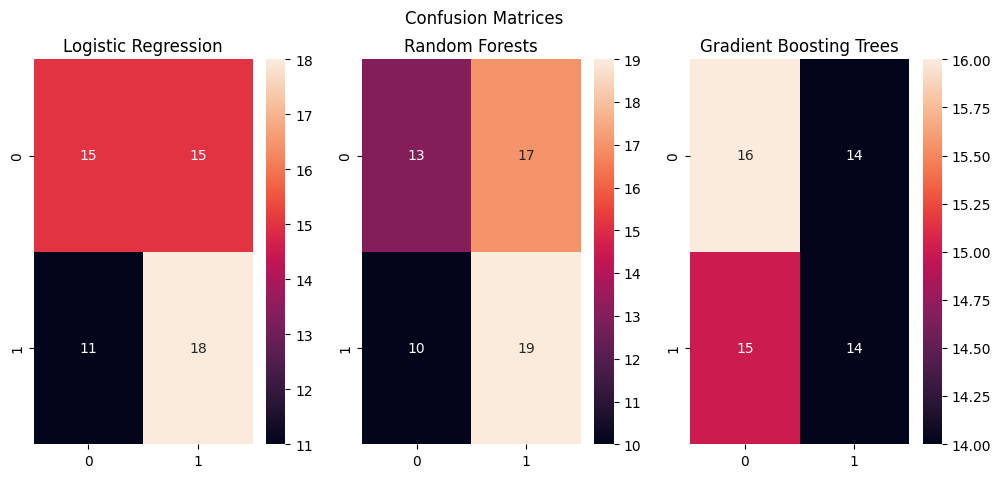

In [35]:
from sklearn.metrics import confusion_matrix

fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,5))
fig.suptitle('Confusion Matrices')

# Logistic Regression
cm = confusion_matrix(y_test,y_pred_best_lr)
sns.heatmap(cm,annot=True, ax=ax1)
ax1.set_title('Logistic Regression')

# Random Forests
cm = confusion_matrix(y_test,y_pred_best_rf)
sns.heatmap(cm,annot=True, ax=ax2)
ax2.set_title('Random Forests')

# Gradient Boosting Trees
cm = confusion_matrix(y_test,y_pred_best_gbt)
sns.heatmap(cm,annot=True, ax=ax3)
ax3.set_title('Gradient Boosting Trees')

## Bias-Variance Trade Off

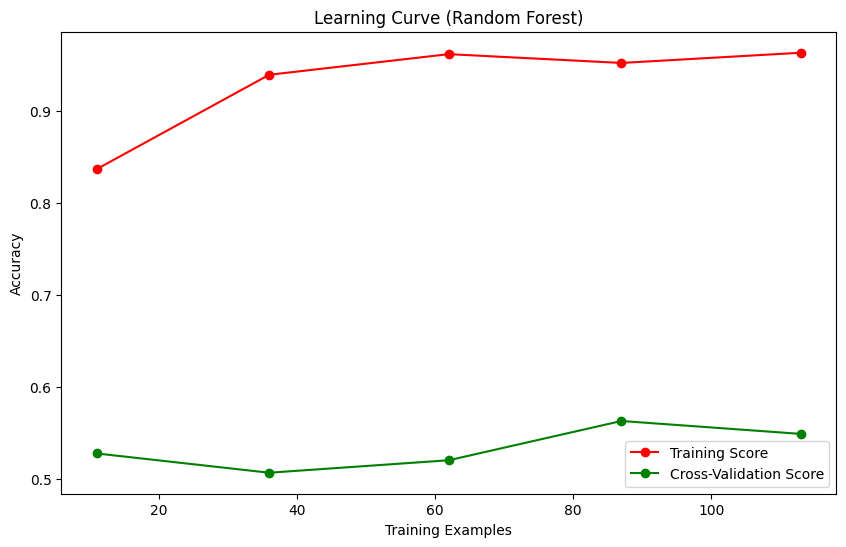

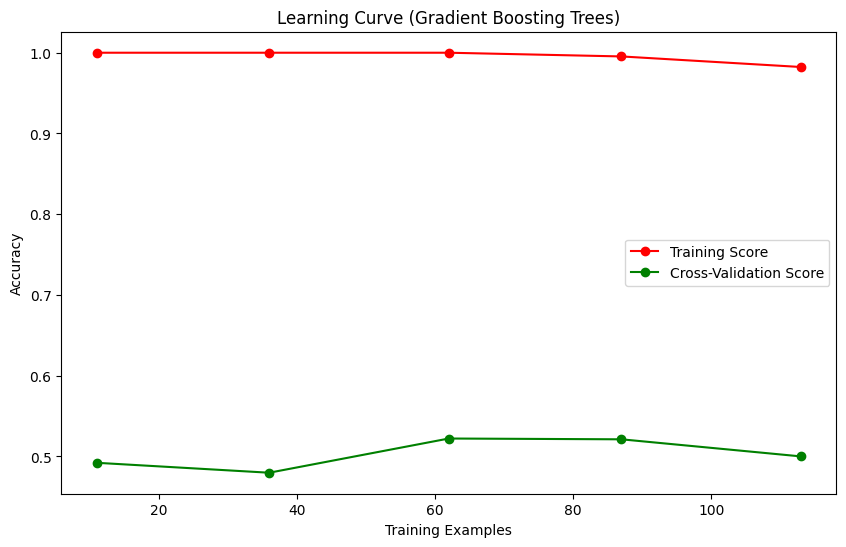

In [36]:
from sklearn.model_selection import learning_curve

# Function to plot the learning curve for the input estimator
def plot_learning_curve(estimator, title, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend(loc="best")
    plt.show()

# Plot learning curve for Random Forest
plot_learning_curve(best_rf, "Learning Curve (Random Forest)", X_train_balanced, y_train_balanced)

# Plot learning curve for Gradient Boosting Trees
plot_learning_curve(gbt, "Learning Curve (Gradient Boosting Trees)", X_train_balanced, y_train_balanced)
